In [8]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install numpy pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# %matplotlib inline은 주피터에서만 필요합니다. 일반 .py 파일에서는 주석 처리하거나 제거
# %matplotlib inline

# 데이터 불러오기
titanic_df = pd.read_csv('./train.csv')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


데이터 세트 Null 값 갯수: 0
Sex 값 분포:
 Sex
male      577
female    314
Name: count, dtype: int64

Cabin 값 분포:
 Cabin
N              687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
              ... 
E17              1
A24              1
C50              1
B42              1
C148             1
Name: count, Length: 148, dtype: int64

Embarked 값 분포:
 Embarked
S    644
C    168
Q     77
N      2
Name: count, dtype: int64
0    N
1    C
2    N
Name: Cabin, dtype: object


C:\Users\user\AppData\Local\Temp\ipykernel_12540\475614690.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_12540\475614690.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

<Axes: xlabel='Pclass', ylabel='Survived'>

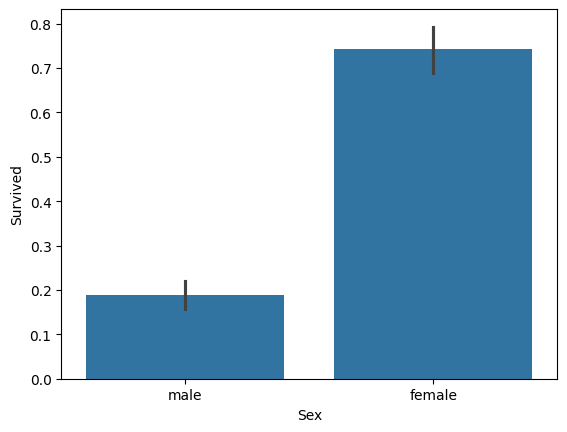

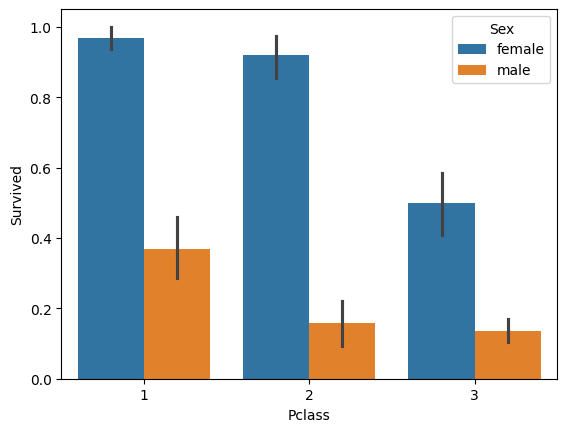

In [11]:
# Null 처리
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 갯수:', titanic_df.isnull().sum().sum())

# 값 분포 확인
print('Sex 값 분포:\n', titanic_df['Sex'].value_counts())
print('\nCabin 값 분포:\n', titanic_df['Cabin'].value_counts())
print('\nEmbarked 값 분포:\n', titanic_df['Embarked'].value_counts())

# Cabin 앞 글자만 추출
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

# 시각화
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()
sns.barplot(x='Sex', y='Survived', data=titanic_df)
plt.figure()
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

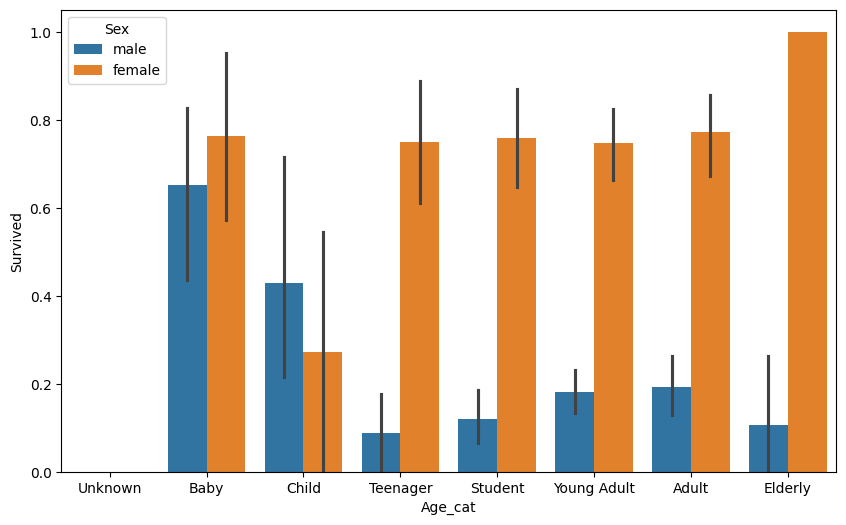

In [12]:
# 나이 구간 분류 함수
def get_category(age):
    if age <= -1:
        return 'Unknown'
    elif age <= 5:
        return 'Baby'
    elif age <= 12:
        return 'Child'
    elif age <= 18:
        return 'Teenager'
    elif age <= 25:
        return 'Student'
    elif age <= 35:
        return 'Young Adult'
    elif age <= 60:
        return 'Adult'
    else:
        return 'Elderly'

plt.figure(figsize=(10,6))
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)


In [13]:
# 전처리 함수 정의
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [14]:
# 원본 데이터 다시 불러와서 분할
titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

# 학습 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

# 모델 선언
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(max_iter=1000)  # max_iter 추가

# 모델 학습 및 평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))  # 오타 수정: lr_pr → lr_pred


C:\Users\user\AppData\Local\Temp\ipykernel_12540\12503227.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_12540\12503227.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8492


In [15]:
# KFold 교차 검증 함수 정의
def exec_kfold(clf, folds=5):
    kfold = KFold(n_splits=folds)
    scores = []
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    print("평균 정확도: {0:.4f}".format(np.mean(scores)))

exec_kfold(dt_clf, folds=5)


교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [16]:
# cross_val_score로 검증
scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for i, acc in enumerate(scores):
    print(f"교차 검증 {i} 정확도: {acc:.4f}")
print("평균 정확도: {0:.4f}".format(np.mean(scores)))

# GridSearchCV
parameters = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 5, 8]
}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy))


교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715
